## Mount Google Drive locally

Mount your Google Drive on your runtime using an authorization code



In [23]:
from google.colab import drive
drive.mount('/content/drive')

dataset_location = "/content/drive/MyDrive/TFScale VGG16 Demo/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***
## Import libraries and initialize values

* Line 16: prepare the ```path``` to the "Plant" folder in the Google Drive
* Line 17: define the input image ```dimension``` of the network
* Line 18: define the ```Batch Size```
* Line 19: define the number of ```Epochs```
* Line 24-25: initialize an empty array for ```data``` and ```labels```

In [34]:
import os
import cv2
import numpy as np
import tensorflow as tf
import numpy as np
import random
from imutils import paths
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import vgg16, resnet50
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras import layers

dataset_path = dataset_location
IMAGE_DIMS = (224, 224, 3)
BS = 32
EPOCHS = 50
print("Tensorflow version %s"%tf.__version__)
print("opencv version %s"%cv2.__version__)

# initialize the data and labels
data = []
labels = []

Tensorflow version 2.8.0
opencv version 4.1.2


***
## Prepare the input images / data

* Line 3: obtain the list of image filenames
* Line 4-5: shuffle (randomise) the list
* Line 7: loop through each image file
* Line 10: read the image
* Line 11: resize the image
* Line 12: convert the image from OpenCV format to normal array
* Line 13: add the image to the ```data``` array
* Line 17: extract the name only from the filename
* Line 18: add the name as label into the ```labels``` array

In [35]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images(dataset_path)))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for ind, imagePath in enumerate(imagePaths):
	# load the image, pre-process it, and store it in the data list
	print(ind, imagePath, imagePath.split(os.path.sep)[-2])
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)
 
	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)
print("Done!")

[INFO] loading images...
0 /content/drive/MyDrive/TFScale VGG16 Demo/data/Coleus/Coleus27.jpg Coleus
1 /content/drive/MyDrive/TFScale VGG16 Demo/data/Chinese Ixora/Chinese Ixora13.jpg Chinese Ixora
2 /content/drive/MyDrive/TFScale VGG16 Demo/data/Dill/Dill43.jpg Dill
3 /content/drive/MyDrive/TFScale VGG16 Demo/data/Coleus/Coleus24.jpg Coleus
4 /content/drive/MyDrive/TFScale VGG16 Demo/data/Chinese Ixora/Chinese Ixora41.jpg Chinese Ixora
5 /content/drive/MyDrive/TFScale VGG16 Demo/data/Celosia Argentea/Celosia Argentea30.jpg Celosia Argentea
6 /content/drive/MyDrive/TFScale VGG16 Demo/data/Aeschynanthus pulcher (Blume) G.Don (Lipstick Plant) (Online)/Aeschynanthus pulcher (Blume) G.Don23.jpg Aeschynanthus pulcher (Blume) G.Don (Lipstick Plant) (Online)
7 /content/drive/MyDrive/TFScale VGG16 Demo/data/Aeschynanthus pulcher (Blume) G.Don (Lipstick Plant) (Online)/Aeschynanthus pulcher (Blume) G.Don_1.jpg Aeschynanthus pulcher (Blume) G.Don (Lipstick Plant) (Online)
8 /content/drive/MyDriv

* Line 2: normalize the image
* Line 2-3: convert the ```data``` and ```labels``` into *numpy* array
* Line 4-5: display the size of the ```data```

In [36]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
	data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 392.78MB


Neural network is not able to accept string (text) as labels, one-hot enconding is an approach to convert text into integer values.

* Line 2-3: Perform one-hot encoding on the ```labels```.



In [37]:
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

* Line 3-4: perform train-test split

In [38]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

---
##**DEMO**
##Load Model from Google Drive

In [39]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/TFScale VGG16 Demo/model/plant.h5')
loss, acc = loaded_model.evaluate(testX, testY, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

3/3 - 6s - loss: 0.4101 - accuracy: 0.8806 - 6s/epoch - 2s/step
Restored model, accuracy: 88.06%


## Load an image for testing

* Line 2: load an image
* Line 6: resize the image
* Line 7: convert to *RGB* for display purpose (OpenCV format is *BGR*)
* Line 8: normalise the image
* Line 9-10: prepare the image into array

In [40]:
# load the image
image = cv2.imread(dataset_path + '/Dill/Dill24.jpg')

# pre-process the image for classification
image = cv2.resize(image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
image_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

* Line 1-2: import matplotlib and set the output to within colab (inline)
* Line 6: Perform classification
* Line 7: obtain the ***```index```*** with the highest probability
* Line 8: Obtain the label of the ```index```
* Line 10-12: display image and predicted label

[INFO] classifying image...


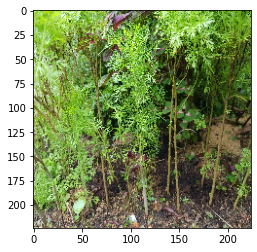

Dill
5


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

# classify the input image
print("[INFO] classifying image...")
proba = loaded_model.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]

plt.imshow(image_display)
plt.show()
print(label)
print(idx)

***
## Prepare the model (using transfer learning)

* Line 5: obtain the VGG16 pre-trained model ***without*** the dense classification layers.
* Line 8: obtain the ResNet pre-trained model.
* Line 12-13: Set all the base pre-trained layer to be ***un-trainable***
* Line 16: Create the model and initialise it with the pre-trained layers
* Line 17-18: creating the desnse layers for classification
* Line 20-22: compile the model
* Line 24: display a summary of the model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
# initialize the model
print("[INFO] compiling model...")

# Load VGG16 model without the top layers
base_layers = vgg16.VGG16(include_top=False, input_shape=IMAGE_DIMS)

# Allow fine tuning to go into the convolution layers 32, 94, 136, 168
base_layers_to_train = 0
for i in range(0, len(base_layers.layers) - base_layers_to_train):
    base_layers.layers[i].trainable = False
for i in range(len(base_layers.layers) - base_layers_to_train, len(base_layers.layers)):
    base_layers.layers[i].trainable = True
    print("%s is set trainable"%base_layers.layers[i].name)

base_layers.summary()
print("total %d layers"%len(base_layers.layers) )

hidden_layers_to_add = [] # No hidden layer
#hidden_layers_to_add = [128] # One hidden layer with 128 nodes
#hidden_layers_to_add = [128, 64] # Two hidden layers with 128 and 64 nodes respectively

# Data augmentation flip, rotate and zoom
#data_augmentation = keras.Sequential(
#  [
#    layers.RandomFlip("horizontal",input_shape=(224,224,3)),
#    layers.RandomRotation(0.1),
#    layers.RandomZoom(0.1),
#  ]
#)

# Create the network
#network = models.Sequential([data_augmentation, base_layers])
network = models.Sequential([base_layers])

# Add dropout layer
#network.add(layers.Dropout(0.2))
network.add(layers.Flatten())
for node in hidden_layers_to_add:
  network.add(layers.Dense(node, activation='sigmoid'))
network.add(layers.Dense(10, activation='softmax'))

# Compile the model
#network.compile(optimizer='rmsprop',
#                loss='categorical_crossentropy',
#                metrics=['accuracy'])
network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
#network.compile(optimizer='sgd',
#                loss='categorical_crossentropy',
#                metrics=['accuracy'])

# Display a summary of the model
network.summary()

***
## Perform training and testing

* Line 1: reducing learning rate over time
* Line 2: early stop if the validation loss stops improving
* Line 3: perform training
* Line 4: perform testing
* Line 5: display test result

In [ ]:
%%time
reduce = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, mode='auto')
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-4, patience=10, mode='auto')
history = network.fit(trainX, trainY, epochs=EPOCHS, batch_size=BS, verbose=2, callbacks=[reduce, early])
test_loss, test_acc = network.evaluate(testX, testY, verbose=2)
print('accuracy: {:5.2f}%'.format(100 * test_acc))

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
#val_acc = history.history['test_acc']

loss = history.history['loss']
#val_loss = history.history['test_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
#plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Save model to Google Drive

In [ ]:
network.save("Plant.h5")

***
## Load an image for testing

* Line 2: load an image
* Line 6: resize the image
* Line 7: convert to *RGB* for display purpose (OpenCV format is *BGR*)
* Line 8: normalise the image
* Line 9-10: prepare the image into array

In [ ]:
# load the image
image = cv2.imread(dataset_path + '/Dill/Dill24.jpg')

# pre-process the image for classification
image = cv2.resize(image, (IMAGE_DIMS[0], IMAGE_DIMS[1]))
image_display = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

* Line 1-2: import matplotlib and set the output to within colab (inline)
* Line 6: Perform classification
* Line 7: obtain the ***```index```*** with the highest probability
* Line 8: Obtain the label of the ```index```
* Line 10-12: display image and predicted label

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# classify the input image
print("[INFO] classifying image...")
proba = network.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]

plt.imshow(image_display)
plt.show()
print(label)
print(idx)